### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [21]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

In [22]:
mth = rets.index[0]
start_mth = mth + pd.DateOffset(months=1)
start_mth

Timestamp('2000-08-01 00:00:00')

In [23]:
#rank transform wrds
dfs = []
for name, df_group in wrds_svm.groupby(['MonthStart']):
    ranked_df = df_group.loc[:,'srcq':'Vol'].rank(axis = 0)/(len(df_group)+1)
    standardized_df = (ranked_df - ranked_df.mean(axis = 0))/ranked_df.std(axis = 0)
    standardized_df.drop(columns= ['DIFFYear', 'date', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays', 'DIFFExpectedDaysCorr'], inplace = True)
    dfs.append(standardized_df)
wrds_standard = pd.concat(dfs, axis = 0, ignore_index= False)

In [24]:
#groupby then rank within groups
flattened_returns = rets.melt(ignore_index=False, var_name='tic').reset_index()
flattened_returns = flattened_returns.rename(columns ={'StartMonth': 'MonthStart'})
flattened_returns.index = pd.MultiIndex.from_frame(flattened_returns[['MonthStart', 'tic']])
flattened_returns.drop(columns = ['MonthStart', 'tic'], inplace=True)
dataset = pd.merge(flattened_returns, wrds_standard, left_index=True, right_index=True, how = 'inner')
dataset.sort_index(inplace=True)

In [48]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))
#preprocessing
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
cols =  ['INV3', 'PRO6', 'INV1'] 
Y = wrds_tics.loc[:,cols] # Y matrix in formulation

def padm_data_treatment(Y):
    # Y['Momentum'] = wrds_tics.Momentum
    #restrict the wharton research data to the columns of interest
    Y_ = (Y.rank(axis = 0)/(len(Y))+1)
    Y_ =  (Y_ - Y_.mean(axis=0))/(Y_.std(axis=0)) #scale the features
    return Y_

Y = padm_data_treatment(Y)

ret_constr = 0.01 #no return constraint
soft_margin = 10 #large preference for separation feasibility

name = "final_lightreg"
ratio = 0.7 #% of assets
card_desc = "Card07"

turnover_descs = ["0_75", "1", "1_25"]
turnovers = [0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
epsilons = [1e-2, 1e-3, 1e-4]
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4"}
card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}

dpi_setting = 150

In [49]:
MVO_ = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon)
SVM_ = SVM(tics, Y , soft_margin*np.ones_like(mean), non_neg = non_negativity_setting, epsilon=epsilon)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 3, ParamLim = 5)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05
SVM_MVO_Fast.MVO_.model.params.timelimit = 10
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.track_change = False #determine global convergence if z has change by more than 20%
SVM_MVO_Fast.change_threshold = 0.2 #if z has changed by twenty percent or more then we have achieved convergence

start = time.time()
SVM_MVO_Fast.silence_output()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Initialization successful
Solution time 6.994006156921387


In [56]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim,\
             svm_choice = (True, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 862 rows, 862 columns and 4576 nonzeros
Model fingerprint: 0x41fec8d0
Model has 41044 quadratic objective terms
Variable types: 576 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Presolve removed 20 rows and 305 columns
Presolve time: 0.01s
Presolved: 842 rows, 557 columns, 4195 nonzeros
Presolved model has 41044 quadratic objective terms
Variable types: 290 continuous, 267 integer (267 binary)

Root relaxation: objective 6.862430e-04, 651 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0         

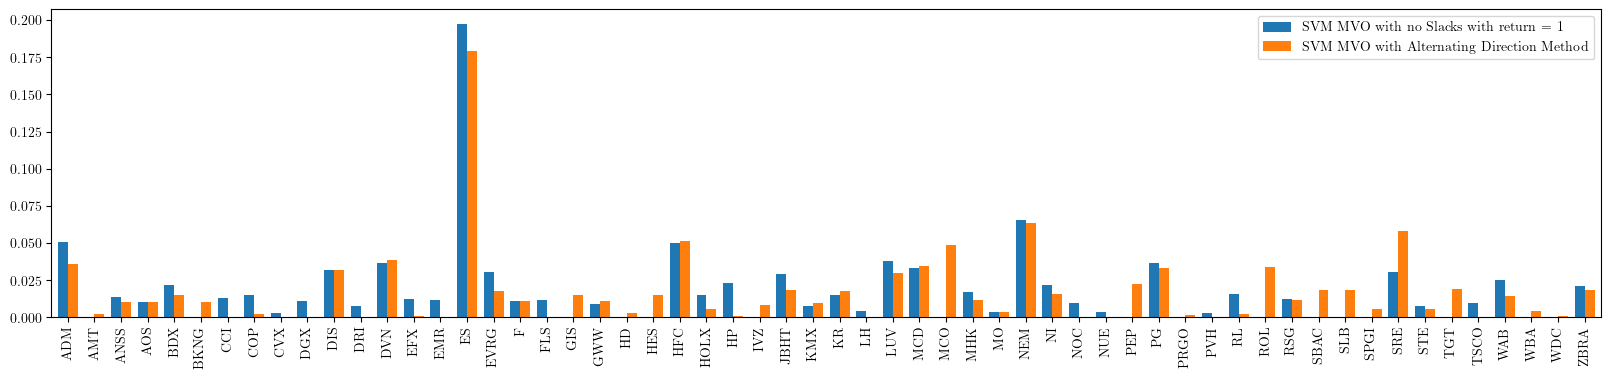

In [51]:
# plt.plot(MVO2.x.x)
# plt.plot(SVM_MVO_Fast.x.x)
out = pd.concat([MVO2.get_results(), SVM_MVO_Fast.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

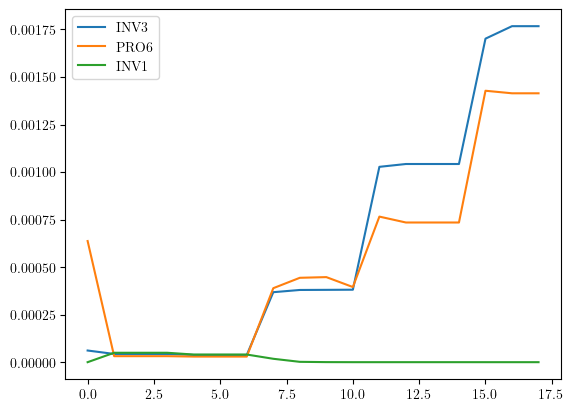

In [52]:
plt.plot(ws)
plt.legend(cols)

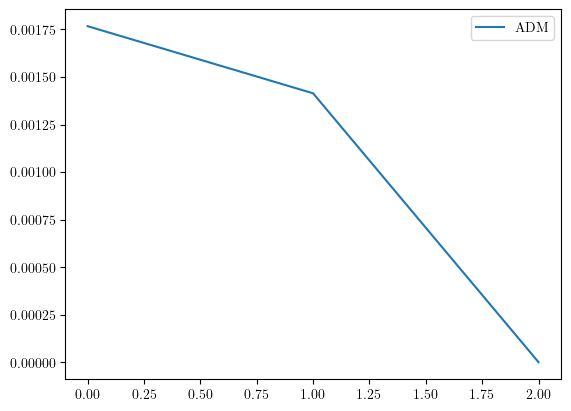

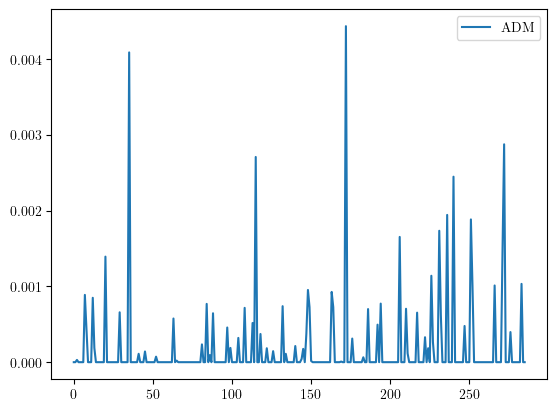

In [53]:
# plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
plt.legend();

plt.figure()
#plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
plt.legend();

In [54]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

In [55]:
"".join(map(str, cols))

'INV3PRO6INV1'

In [57]:
"_INV3PRO6INV1_"for ratio, epsilon in product(ratios, epsilons):
    AssetLim = math.floor(N*ratio)

    SVM_MVO_Fast.MVO_.AssetLim = AssetLim
    SVM_MVO_Fast.MVO_.epsilon = epsilon
    SVM_MVO_Fast.SVM_.epsilon = epsilon
    card_desc = card_desc_list[ratio]
    print("processing asset limit ", AssetLim)

    isExist = os.path.exists("cache/Local Experiments/"+epsilons_desc[epsilon])
    if not isExist:
        os.makedirs("cache/Local Experiments/"+epsilons_desc[epsilon])
        print("The new directory is created!")
    for i in range(len(turnovers)):
        turnover = turnovers[i]
        turnover_desc = turnover_descs[i]
        adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols,
                 turnover, data_treatment=padm_data_treatment)
        col_string = "".join(map(str, cols))
        out_pth = "cache/Local Experiments/"+epsilons_desc[epsilon] + "/" + "padm" +card_desc + "_" +col_string + "_" +turnover_desc + name + ".pkl"
        with open(out_pth, 'wb') as fp:
            pkl.dump(adm_results, fp)
#end here for now - 1:32 AM 2022 - 10 22

processing asset limit  28
Begin Relaxation
ADM terminated with C =  1.0000000000000003e-05
_________________________
Iteration  0
Percent Complete  0.0
[3.80952850e-05 3.94422831e-05 1.85024762e-09]
_________________________
Iteration  12
Percent Complete  0.04938271604938271
[2.75774888e-05 2.88880207e-05 4.83240637e-10]
Infeasible return constraint...Relaxing
_________________________
Iteration  24
Percent Complete  0.09876543209876543
[2.37791828e-05 2.52222436e-05 6.00059642e-10]
Infeasible return constraint...Relaxing
_________________________
Iteration  36
Percent Complete  0.14814814814814814
[5.92776291e-05 6.09304053e-05 3.63950103e-09]
_________________________
Iteration  48
Percent Complete  0.19753086419753085
[2.26973957e-05 2.40837924e-05 3.27639099e-09]
_________________________
Iteration  60
Percent Complete  0.24691358024691357
[1.90464194e-05 2.03140264e-05 7.83858740e-10]
_________________________
Iteration  72
Percent Complete  0.2962962962962963
[2.90952914e-05 3.